In [183]:
from pacti.contracts import PolyhedralIoContract
import numpy as np
import matplotlib.pyplot as plt

## CONSTANTS
a_i = 0.5
d_i = 1
a_ip = 10
d_ip = 1
a_j = 1
d_j = 1
a_jp = 10
d_jp = 1
kappa = 20
delta = 1

# computed constants
b_i = a_i / d_i
b_ip = a_ip / d_ip
b_j = a_j / d_j
b_jp = a_jp / d_jp

# requirement values first scenario
A_i_H = 45
A_j_L = 0.02
m_i_H = 1
m_j_L = 0.00005
# requirement values second scenario
A_j_H = 90
A_i_L = 0.05
m_j_H = 0.25
m_i_L = 0.0001

In [184]:
assert A_j_L/m_j_L - A_i_H/m_i_H >= 0 
assert A_i_L/m_i_L - A_j_H/m_j_H >= 0

In [185]:
top_level_sc1 = PolyhedralIoContract.from_strings(
    input_vars=[],
    output_vars=["m_i", "m_j", "A_i", "A_j"],
    assumptions=[],
    guarantees=[f"m_i >= {m_i_H}", f"m_j <= {m_j_L}", f"A_i >= {A_i_H}", f"A_j <= {A_j_L}"]
)

monotonicity_component1_sc1 = PolyhedralIoContract.from_strings(
    input_vars=["p_i","p_j","q_i","q_j"],
    output_vars=["m_i"],
    assumptions=["q_i >= p_i"],
    # assumptions=[],
    guarantees=[f"{delta}*m_i >= {1/(1 + b_i*A_i_H + b_ip*A_j_L)}*p_i + {A_i_H*b_i/(1 + b_i*A_i_H + b_ip*A_j_L)}*q_i"]
)
# RHS above is >= m_i_H

monotonicity_component2_sc1 = PolyhedralIoContract.from_strings(
    input_vars=["p_i","p_j","q_i","q_j"],
    output_vars=["m_j"],
    assumptions=[f"{1 + b_jp*A_i_H} * q_j >= p_j"],
    # assumptions=["q_j >= p_j"],
    # assumptions=[],
    guarantees=[f"{delta}*m_j <= {1/(1 + b_j*A_j_L + b_jp*A_i_H)}*p_j + {A_j_L*b_j/(1 + b_j*A_j_L + b_jp*A_i_H)}*q_j"]
)
# RHS above is <= m_j_L

A_definition_sc1 = PolyhedralIoContract.from_strings(
    input_vars=["gamma_inv"],
    output_vars=["A_i", "A_j"],
    assumptions=[],
    guarantees=[
                f"{kappa * m_i_H} * gamma_inv <= A_i",
                f"A_j <= {kappa * m_j_L}  * gamma_inv"]
)

# compute the parameters that yield the first set of top-level requirements
# test_contract = top_level_sc1.quotient(A_definition_sc1)
composed_contract1 = monotonicity_component1_sc1.compose(monotonicity_component2_sc1).compose(A_definition_sc1)
parameters_contract_1 = top_level_sc1.quotient(composed_contract1)


##################
## Now we analyze the second scenario: when m_i < m_i_L and m_j > m_J_H

top_level_sc2 = PolyhedralIoContract.from_strings(
    input_vars=[],
    output_vars=["m_i", "m_j", "A_i", "A_j"],
    assumptions=[],
    guarantees=[f"m_j >= {m_j_H}", f"m_i <= {m_i_L}", f"A_j >= {A_j_H}", f"A_i <= {A_i_L}"]
    )

monotonicity_component1_sc2 = PolyhedralIoContract.from_strings(
    input_vars=["p_i","p_j","q_i","q_j"],
    output_vars=["m_j"],
    assumptions=["q_j >= p_j"],
    # assumptions=[],
    guarantees=[f"{delta}*m_j >= {1/(1 + b_j*A_j_H + b_jp*A_i_L)}*p_j + {A_j_H*b_j/(1 + b_j*A_j_H + b_jp*A_i_L)}*q_j"]
)
# RHS above is >= m_j_H

monotonicity_component2_sc2 = PolyhedralIoContract.from_strings(
    input_vars=["p_i","p_j","q_i","q_j"],
    output_vars=["m_i"],
    assumptions=[f"{1 + b_ip*A_j_H} * q_i >= p_i"],
    # assumptions=["q_i >= p_i"],
    # assumptions=[],
    guarantees=[f"{delta}*m_i <= {1/(1 + b_i*A_i_L + b_ip*A_j_H)}*p_i + {A_i_L*b_i/(1 + b_i*A_i_L + b_ip*A_j_H)}*q_i"]
)
# RHS above is <= m_i_L 

A_definition_sc2 = PolyhedralIoContract.from_strings(
    input_vars=["gamma_inv"],
    output_vars=["A_i", "A_j"],
    assumptions=[],
    guarantees=[f"{kappa * m_j_H} * gamma_inv <= A_j",
                f"A_i <= {kappa * m_i_L}  * gamma_inv "]
)

# compute the parameters that yield the first set of top-level requirements
composed_contract2 = monotonicity_component1_sc2.compose(monotonicity_component2_sc2).compose(A_definition_sc2)
parameters_contract_2 = top_level_sc2.quotient(composed_contract2)

# report the parameter space that yields bistability
parameter_contract = parameters_contract_1.merge(parameters_contract_2)
print(parameter_contract)

InVars: []
OutVars:[p_i, p_j, q_i, q_j, gamma_inv]
A: [
  
]
G: [
  -0.04219 p_i - 0.9494 q_i <= -1
  0.002217 p_j + 4.434e-05 q_j <= 5e-05
  0.001 gamma_inv <= 0.02
  -0.01093 p_j - 0.9836 q_j <= -0.25
  0.00111 p_i + 2.775e-05 q_i <= 0.0001
  -5 gamma_inv <= -90
]


Gamma has the bounds [0.049999999999999954, 0.05555555555555555]


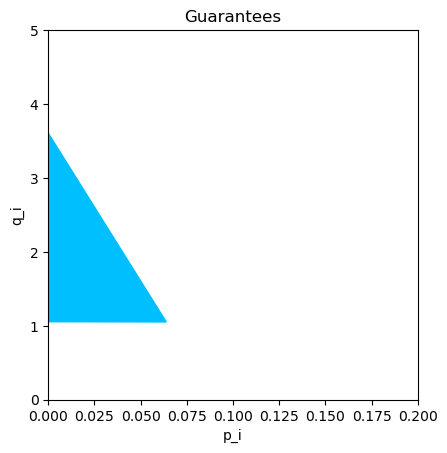

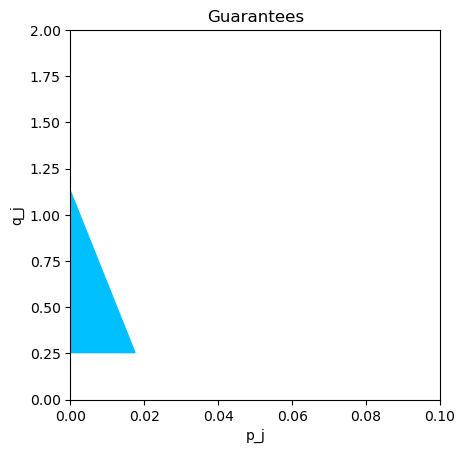

In [192]:
from pacti.iocontract import Var
from pacti.terms.polyhedra import PolyhedralTermList
from pacti.utils.plots import plot_guarantees

# gamma
gamma_inv_bounds = parameter_contract.get_variable_bounds("gamma_inv")
gamma_bounds = [1/e for e in reversed(list(gamma_inv_bounds))]
print(f"Gamma has the bounds {gamma_bounds}")

# q_i and p_i
contract_i = PolyhedralIoContract(
    assumptions=PolyhedralTermList(),
    guarantees=parameter_contract.g.get_terms_with_vars([Var('p_i'), Var('q_i')]),
    input_vars=[],
    output_vars=[Var('p_i'), Var('q_i')]
    )

# print(contract_i)
ymax1 = 5
fig1 = plot_guarantees(contract=contract_i,x_var="p_i",y_var="q_i",var_values={},
                    x_lims=[0,0.2],y_lims=[0,ymax1],show=True)

# q_j and p_j
contract_j = PolyhedralIoContract(
    assumptions=PolyhedralTermList(),
    guarantees=parameter_contract.g.get_terms_with_vars([Var('p_j'), Var('q_j')]),
    input_vars=[],
    output_vars=[Var('p_j'), Var('q_j')]
    )

# print(contract_j)
ymax2 = 2
fig2 = plot_guarantees(contract=contract_j,x_var="p_j",y_var="q_j",var_values={},
                    x_lims=[0,0.1],y_lims=[0,ymax2],show=True)


In [193]:
print(contract_i.get_variable_bounds("p_i"))
print(contract_i.get_variable_bounds("q_i"))
print(contract_j.get_variable_bounds("p_j"))
print(contract_j.get_variable_bounds("q_j"))

(None, 0.06384010011122464)
(1.0504959955506123, None)
(None, 0.017471549233210492)
(0.25397253834185324, None)


In [194]:
# Find a method on contract_i to check whether given values of p_i and q_i are feasible according to contract_i.g or not
# Now create a grid of values for p_i and q_i and check which ones are feasible using the above check to finally end up with feasible array values
p_i_values = np.linspace(0,contract_i.get_variable_bounds("p_i")[1],100)
q_i_values = np.linspace(contract_i.get_variable_bounds("q_i")[0], ymax1, 100)
feasible_pi_qi_values = []
for i, p_iv in enumerate(p_i_values):
    for j, q_iv in enumerate(q_i_values):
        if contract_i.g.contains_behavior({Var('p_i'): p_iv, Var('q_i'): q_iv}):
            feasible_pi_qi_values.append((p_iv, q_iv))

p_j_values = np.linspace(0,contract_j.get_variable_bounds("p_j")[1],100)
q_j_values = np.linspace(contract_j.get_variable_bounds("q_j")[0], ymax2, 100)
feasible_pj_qj_values = []
for i, p_jv in enumerate(p_j_values):
    for j, q_jv in enumerate(q_j_values):
        if contract_j.g.contains_behavior({Var('p_j'): p_jv, Var('q_j'): q_jv}):
            feasible_pj_qj_values.append((p_jv, q_jv))
# Choose a fixed value of gamma
gamma_s = (gamma_bounds[0] + gamma_bounds[1]) / 2

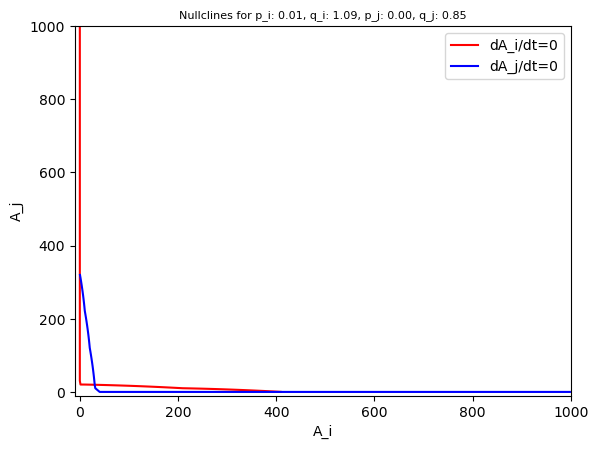

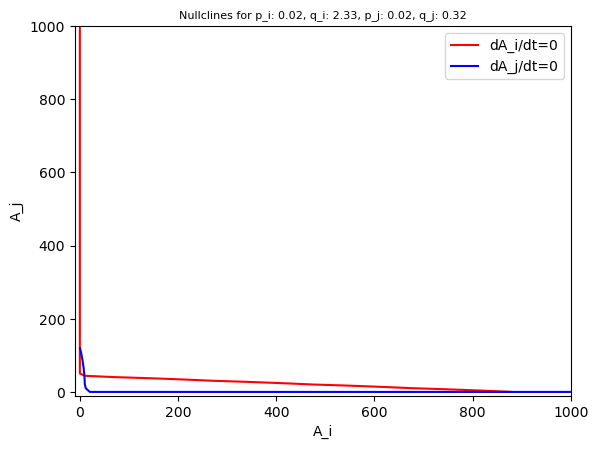

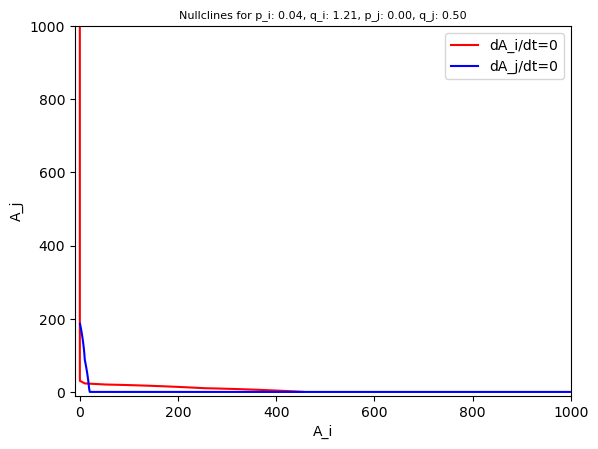

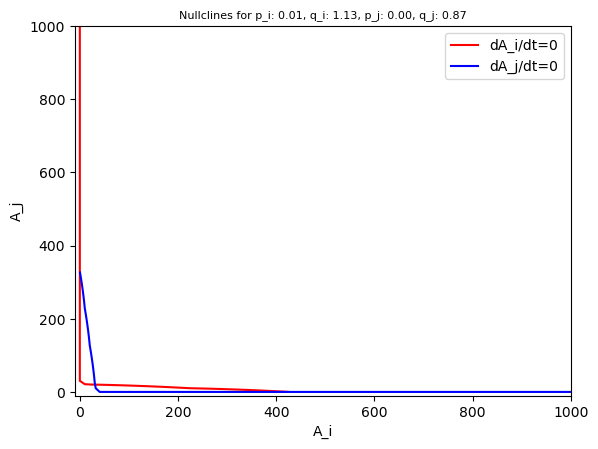

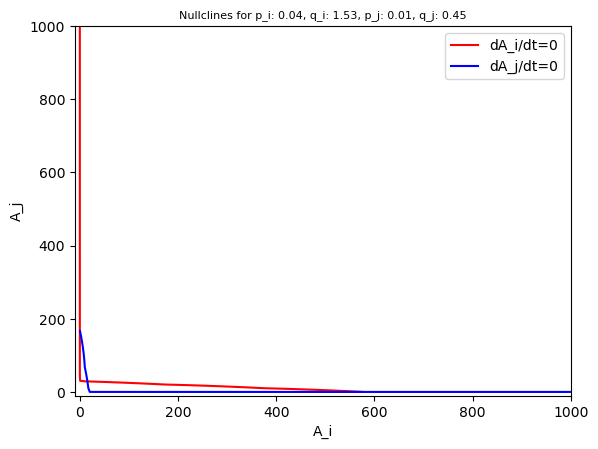

In [196]:
def plot_nullclines(p_i, p_j, q_i, q_j, gamma, **kwargs):
    title = kwargs.get('title', f"p_i: {p_i:.2f}, q_i: {q_i:.2f}, p_j: {p_j:.2f}, q_j: {q_j:.2f}, gamma: {gamma:.2f}")
    # Nullclines
    A_i = np.linspace(0, 1000, 100)
    A_j = np.linspace(0, 1000, 100)
    X1, X2 = np.meshgrid(A_i, A_j)
    U = ( (kappa/delta) * (p_i + b_i*q_i*X1)) / (1 + b_i*X1 + b_ip*X2) - gamma * X1
    V = ( (kappa/delta) * (p_j + b_j*q_j*X2)) / (1 + b_j*X2 + b_jp*X1) - gamma * X2
    import matplotlib.lines as mlines 

    # Plot nullclines
    fig, ax = plt.subplots()

    # Label the contours
    ax.contour(X1, X2, U, levels=[0], colors='r')
    ax.contour(X1, X2, V, levels=[0], colors='b')

    # Create proxy artists
    red_line = mlines.Line2D([], [], color='r', label='dA_i/dt=0')
    blue_line = mlines.Line2D([], [], color='b', label='dA_j/dt=0')

    # Add the legend manually to the current Axes.
    ax.legend(handles=[red_line, blue_line], loc='upper right')

    ax.set_xlabel('A_i')
    ax.set_ylabel('A_j')
    ax.set_title('Nullclines for ' + title, fontsize = 8)
    # Set xlim and ylim from -10 to 100
    ax.set_xlim(-10, 1000)
    ax.set_ylim(-10, 1000)
    # plt.show()

# Randomly choose 5 values from feasible_pi_qi_values and feasible_pj_qj_values and call plot_nullclines with these values
pi_qi_chosen = np.array(feasible_pi_qi_values)[np.random.choice(len(feasible_pi_qi_values), 5)]
pj_qj_chosen = np.array(feasible_pj_qj_values)[np.random.choice(len(feasible_pj_qj_values), 5)]
for i in range(5):
    pi_s = pi_qi_chosen[i][0]
    qi_s = pi_qi_chosen[i][1]
    pj_s = pj_qj_chosen[i][0]
    qj_s = pj_qj_chosen[i][1]
    # title with 2f precision
    title = f"p_i: {pi_s:.2f}, q_i: {qi_s:.2f}, p_j: {pj_s:.2f}, q_j: {qj_s:.2f}"
    plot_nullclines(pi_s, pj_s, qi_s, qj_s, gamma_s, title = title)